# Hawkes fit to start times
Load the imports:

In [12]:
from preprocessing import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from tqdm import tqdm
from matplotlib.ticker import FuncFormatter
import scipy.optimize as op
plt.style.use("dark_background") # Config plots for dark mode, delete if on light mode
plt.rcParams['figure.dpi'] = 150 # Hi-res plots

We will use the following kernel:
$$
\mu_i(t) = \alpha_i e^{-\beta_i t},\, 0 \leq \alpha_i \leq \beta_i
$$

In [13]:
def hawkes_log_likelihood(t, alpha, beta, lambda_p): 
    ratio = alpha/beta
    A = []
    for i in range(0, len(t)):
        if i==0:
            A.append(0)
        else:
            A.append(np.exp(-1*beta*(t[i] - t[i-1]))*(1+A[i-1]))
    A = np.array(A)
    first_sum = np.sum(np.log(lambda_p + alpha*A))
    tk = t[-1]
    second_sum = ratio * np.sum(np.exp(-beta*(tk - t)) - 1)
    ret = first_sum + second_sum - lambda_p*tk
    return ret

#hawkes_log_likelihood(train_sorted_stations_start[0].start_time.to_numpy(),1,1,1)


In [14]:
# optimal_parameters = {}
# for station in tqdm(train_sorted_stations_start):
#     x0 = [np.log(0.1), np.log(1), np.log(0.1)] # np.log(rates_dict[station.start_id.unique()[0]])]
#     op_hawkes_likelihood = lambda x: -hawkes_log_likelihood(station.start_time.to_numpy(), np.exp(x[0]), np.exp(x[0]) + np.exp(x[1]), np.exp(x[2]))
#     sol = op.minimize(op_hawkes_likelihood, x0, method="Nelder-Mead")
#     if sol.success:
#         transformed_alpha = np.exp(sol.x[0])
#         transformed_beta = np.exp(sol.x[1]) + np.exp(sol.x[0])
#         transformed_lambda = np.exp(sol.x[2])
#         max_params = [transformed_alpha, transformed_beta, transformed_lambda]
#         optimal_parameters[station.start_id.unique()[0]] = max_params
        
#     else:
#         raise OptimizationError("Failed to converge.")
# optimal_parameters

Compute the compensator $\Lambda(t)$ using the formula found in Laub 15

In [15]:
def goodcompensator(t, alpha, beta, lambda_p):
    t = np.array(t)
    result = [lambda_p*t[0]]
    ratio = alpha/beta
    for k in range(1,len(t)):
            result.append(lambda_p*t[k]-ratio * np.sum(np.exp(-beta * (t[k]-t[:k])) - 1))
    return result

Compute the compensator $\Lambda_j(t_i)$ for each station $j$ and each event time $t_i$

In [16]:
# param_df = pd.DataFrame(optimal_parameters.values(), index=optimal_parameters.keys(), columns = ["alpha", "beta", "lambda"])
# param_df.head()
# param_df.to_csv("../data/parameters/M2_train_params.csv")

In [17]:
# hawkes_parameters = pd.read_csv('../data/parameters/hawkes_parameters.csv', index_col=0)
# hawkes_parameters = param_df
hawkes_parameters = pd.read_csv("../data/parameters/M2_train_params.csv", index_col=0)
hawkes_parameters

,alpha,beta,lambda
1,0.014106,0.023018,0.005462
2,0.021212,0.023021,0.003802
3,0.019415,0.027979,0.004185
4,0.226693,0.942690,0.012930
5,0.022903,0.026077,0.006239
...,...,...,...
836,0.015292,0.022648,0.008637
838,0.017671,0.026426,0.004331
839,0.253133,0.770489,0.028866
840,0.015301,0.015356,0.000055


In [18]:
compensated_times_dict_train = {}
for st_id in tqdm(train_sorted_start_ids):
    params = hawkes_parameters.loc[st_id].to_numpy()
    time = t_per_station[st_id]
    compensated_times_dict_train[st_id] = goodcompensator(time, params[0], params[1], params[2])

compensated_times_dict_test = {}
for st_id in tqdm(test_sorted_start_ids):
    params = hawkes_parameters.loc[st_id].to_numpy()
    time = t_per_station[st_id]
    compensated_times_dict_test[st_id] = goodcompensator(time, params[0], params[1], params[2])

100%|██████████| 788/788 [01:19<00:00,  9.93it/s]


In [19]:
m2_compensated_times_train_df = pd.DataFrame(compensated_times_dict_train.values(), index=compensated_times_dict_train.keys())
m2_compensated_times_train_df.to_csv("../data/compensated_times/M2_compensated_times_train.csv")

In [ ]:
m2_compensated_times_test_df = pd.DataFrame(compensated_times_dict_test.values(), index=compensated_times_dict_test.keys())
m2_compensated_times_test_df.to_csv("../data/compensated_times/M2_compensated_times_test.csv")

In [ ]:
m2_p_values_train = {}
for station_id in compensated_times_dict_train.keys():
    inter_arrival_times = np.diff(compensated_times_dict_train[station_id])
    inter_arrival_times = np.insert(inter_arrival_times,0,compensated_times_dict_train[station_id][0]) #change first inter-arrival time to t_1
    station_p_values = np.exp(-inter_arrival_times)
    m2_p_values_train[station_id] = station_p_values

m2_p_values_test = {}
for station_id in compensated_times_dict_test.keys():
    inter_arrival_times = np.diff(compensated_times_dict_test[station_id])
    inter_arrival_times = np.insert(inter_arrival_times,0,compensated_times_dict_test[station_id][0]) #change first inter-arrival time to t_1
    station_p_values = np.exp(-inter_arrival_times)
    m2_p_values_test[station_id] = station_p_values



In [ ]:
m2_p_values_df_train = pd.DataFrame(m2_p_values_train.values(), m2_p_values_train.keys())
m2_p_values_df_train.to_csv("../data/p_values/M2_p_values_train.csv")
m2_p_values_df_test = pd.DataFrame(m2_p_values_test.values(), m2_p_values_test.keys())
m2_p_values_df_test.to_csv("../data/p_values/M2_p_values_test.csv")

(array([170., 154., 159., 202., 153., 163., 151., 145., 122., 284.]),
 array([4.79110816e-04, 1.00411183e-01, 2.00343255e-01, 3.00275327e-01,
        4.00207399e-01, 5.00139472e-01, 6.00071544e-01, 7.00003616e-01,
        7.99935688e-01, 8.99867760e-01, 9.99799832e-01]),
 <BarContainer object of 10 artists>)

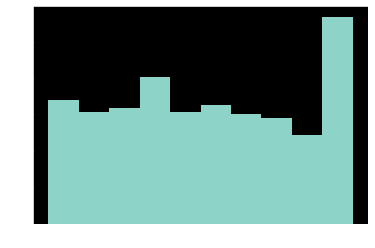

In [14]:
plt.hist(m2_p_values[1])

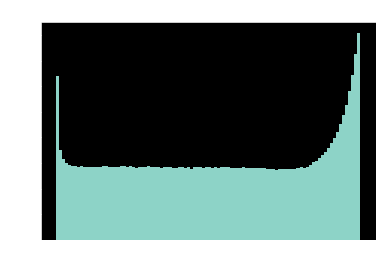

In [15]:
joined_p_values = np.concatenate(np.array(list(m2_p_values.values()), dtype=object))
n, bins, patches = plt.hist(joined_p_values, bins=100)
ax = plt.gca()
def lblFormat(n, pos):
    return str(int(n / 1e3))
lblFormatter = FuncFormatter(lblFormat)
ax.yaxis.set_major_formatter(lblFormatter)
plt.title("Histogram of p-values for all stations for Model 2")
plt.xlabel("P-value")
plt.ylabel("Counts (Thousands)")
plt.savefig("../figures/p-values_m2.png")
plt.show()

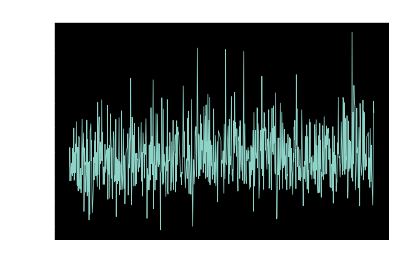

In [16]:
kol_smir_test = {}
for station_id, pvals in m2_p_values.items():
    kol_smir_test[station_id] = st.kstest(pvals, "uniform").statistic

plt.plot(kol_smir_test.keys(), kol_smir_test.values(), linewidth=0.7)
plt.title("Kolmogorov-Smirnov test for all stations for Model 2")
plt.xlabel("Station Id")
plt.ylabel("$D_n$")
plt.savefig("../figures/kol-smir_m2.png")
plt.show()

In [17]:
popularity_dict = {}
for station_id in m2_p_values.keys():
    popularity_dict[station_id] = len(test_bike_data[test_bike_data.start_id == station_id])


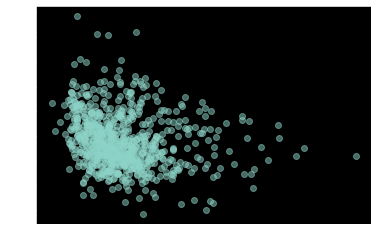

In [18]:
plt.scatter(popularity_dict.values(), kol_smir_test.values(), alpha=0.5)
plt.show()

In [19]:
ks_df = pd.DataFrame(kol_smir_test.values(), index=kol_smir_test.keys(), columns = ["ks"])
ks_df.head()
outlier_ids = ks_df[ks_df.ks > 0.5].index.to_numpy()
print(outlier_ids)
for id in outlier_ids:
    print(optimal_parameters[id])

[]


In [20]:
print(len(train_bike_data[train_bike_data.start_id == 794]))
print(len(train_bike_data[train_bike_data.start_id == 841]))

392
296


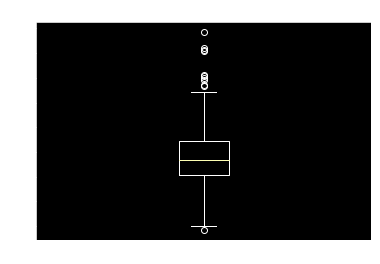

In [21]:
plt.boxplot(kol_smir_test.values())
plt.title("Boxplot of Kolmogorov-Smirnov test statistic for Model 2")
plt.show()

In [22]:
def ecdf(data): # https://cmdlinetips.com/2019/05/empirical-cumulative-distribution-function-ecdf-in-python/
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

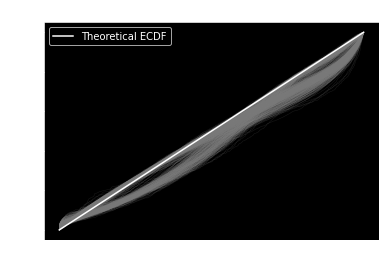

In [23]:
for station, pvals in m2_p_values.items():
    x,y = ecdf(pvals)
    plt.plot(x,y, alpha=0.2, linewidth=0.5, color="gray")

plt.title("ECDF for p-values of Model 2")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], color="white", label="Theoretical ECDF")
plt.legend()
plt.show()

# Test with test set

In [24]:
compensated_test_times_dict = {}
for st_id in tqdm(test_sorted_start_ids):
    params = hawkes_parameters.loc[st_id].to_numpy()
    time = t_per_station[st_id]
    compensated_test_times_dict[st_id] = goodcompensator(time, params[0], params[1], params[2])
#compensated_test_times_dict

100%|██████████| 788/788 [00:44<00:00, 17.73it/s]


In [25]:
m2_p_values_test = {}

for station_id in compensated_test_times_dict.keys():
    test_inter_arrival_times = np.diff(compensated_test_times_dict[station_id])
    test_inter_arrival_times = np.insert(test_inter_arrival_times,0,compensated_test_times_dict[station_id][0]) #change first inter-arrival time to t_1
    station_test_p_values = np.exp(-test_inter_arrival_times)
    m2_p_values_test[station_id] = station_test_p_values

#hawkes_test_p_values[1]

In [26]:
m2_p_values_df = pd.DataFrame(m2_p_values_test.values(), m2_p_values_test.keys())
m2_p_values_df.to_csv("../data/p_values/M2_p_values.csv")

(array([56., 57., 48., 55., 49., 53., 52., 50., 39., 76.]),
 array([6.57815663e-288, 9.99844073e-002, 1.99968815e-001, 2.99953222e-001,
        3.99937629e-001, 4.99922037e-001, 5.99906444e-001, 6.99890851e-001,
        7.99875258e-001, 8.99859666e-001, 9.99844073e-001]),
 <BarContainer object of 10 artists>)

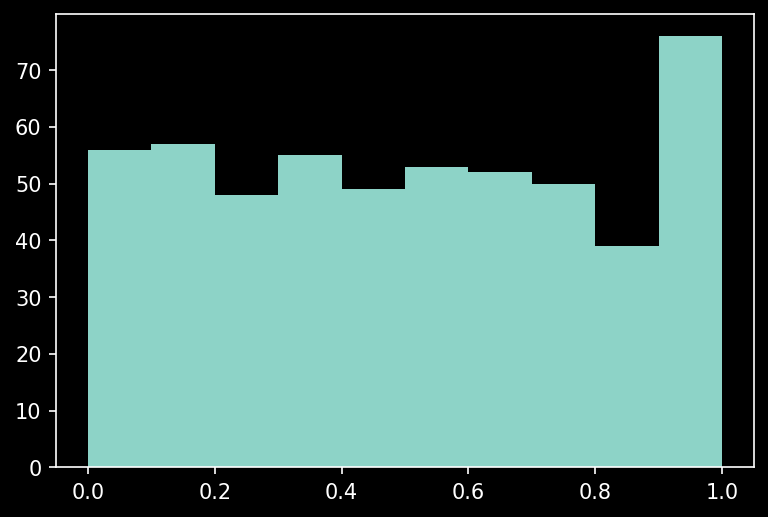

In [23]:
plt.hist(m2_p_values_test[1])

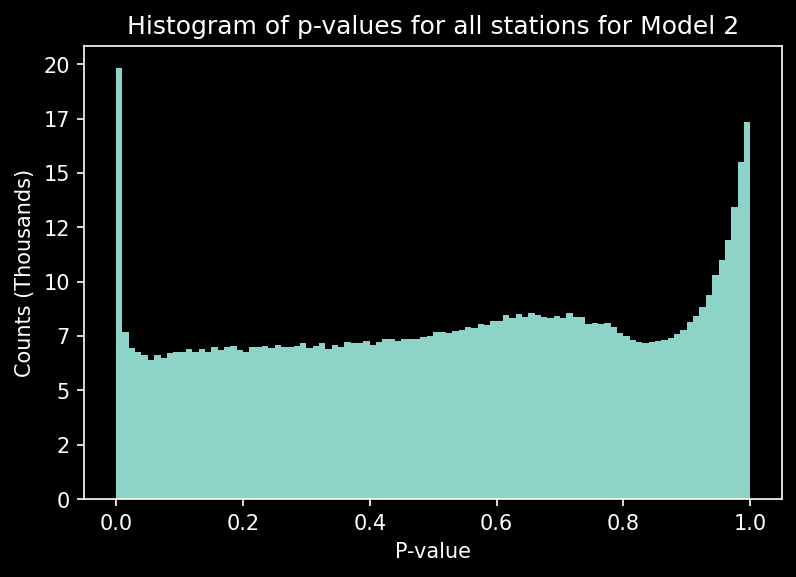

In [24]:
joined_p_values = np.concatenate(np.array(list(m2_p_values_test.values()), dtype=object))
n, bins, patches = plt.hist(joined_p_values, bins=100)
ax = plt.gca()
def lblFormat(n, pos):
    return str(int(n / 1e3))
lblFormatter = FuncFormatter(lblFormat)
ax.yaxis.set_major_formatter(lblFormatter)
plt.title("Histogram of p-values for all stations for Model 2")
plt.xlabel("P-value")
plt.ylabel("Counts (Thousands)")
plt.savefig("../figures/p-values_m2.png")
plt.show()

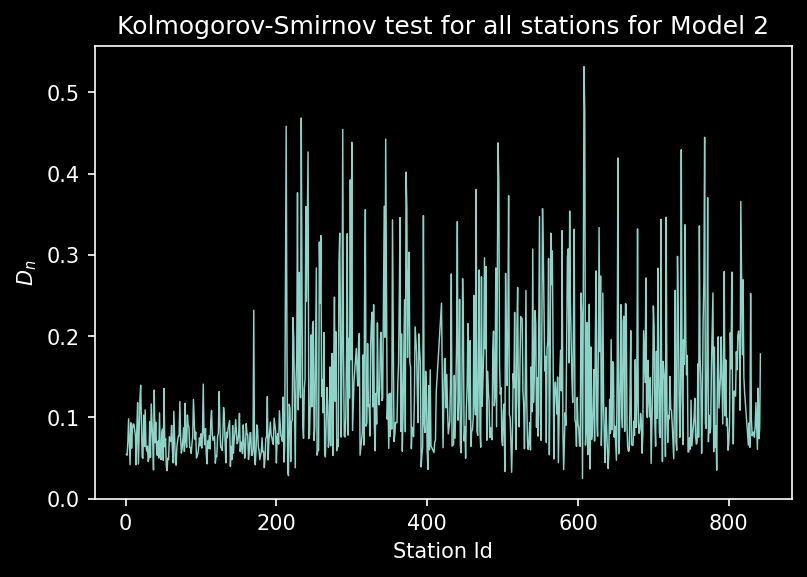

In [28]:
kol_smir_test_test = {}
for station_id, pvals in m2_p_values_test.items():
    kol_smir_test_test[station_id] = st.kstest(pvals, "uniform").statistic

plt.plot(kol_smir_test_test.keys(), kol_smir_test_test.values(), linewidth=0.7)
plt.title("Kolmogorov-Smirnov test for all stations for Model 2")
plt.xlabel("Station Id")
plt.ylabel("$D_n$")
plt.savefig("../figures/kol-smir_m2_test.png")
plt.show()

In [ ]:
# ks_test_df = pd.DataFrame(kol_smir_test_test.values(), index=kol_smir_test_test.keys(), columns = ["ks"])
# ks_test_df.head()
# test_outlier_ids = ks_test_df[ks_test_df.ks > 0.5].index.to_numpy()
# print(test_outlier_ids)
# for id in test_outlier_ids:
#     print(optimal_parameters[id])

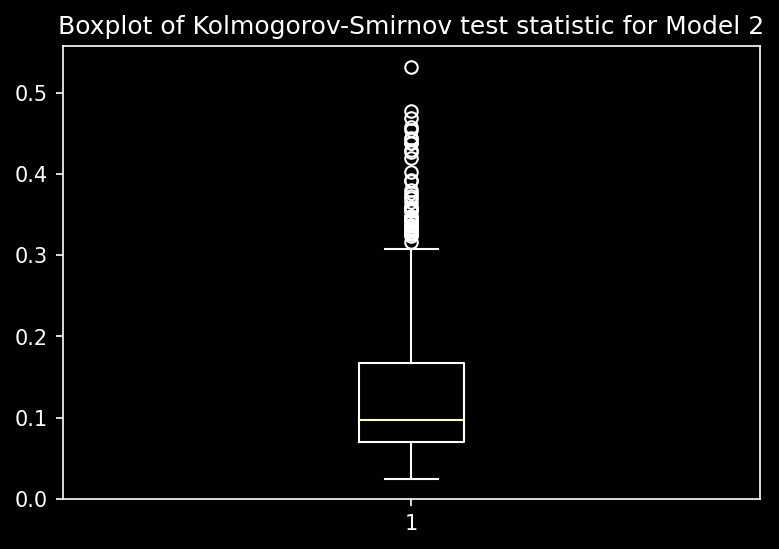

In [29]:
plt.boxplot(kol_smir_test_test.values())
plt.title("Boxplot of Kolmogorov-Smirnoxv test statistic for Model 2")
plt.show()

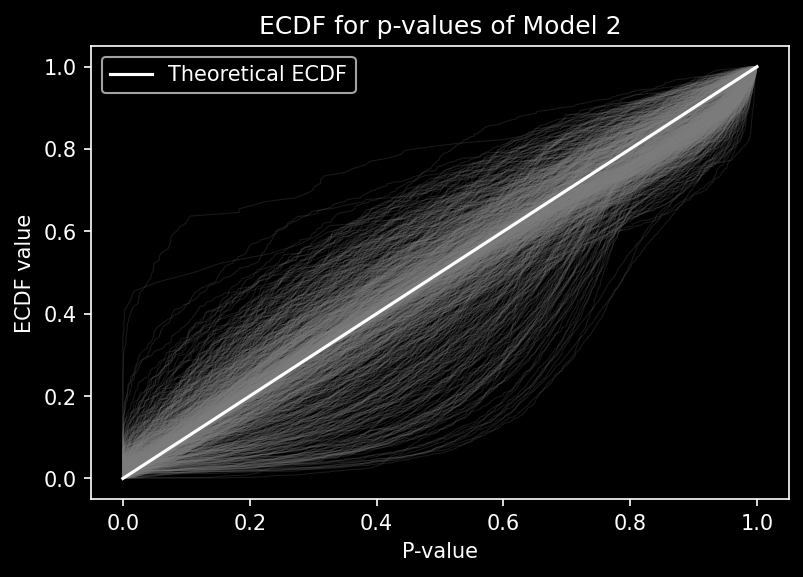

In [34]:
for station, pvals in m2_p_values_test.items():
    x,y = ecdf(pvals)
    plt.plot(x,y, alpha=0.2, linewidth=0.5, color="gray")

plt.title("ECDF for p-values of Model 2")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], color="white", label="Theoretical ECDF")
plt.legend()
plt.show()